In [10]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score




In [21]:
# 1. LOAD YOUR DATA
# -------------------------------
coursera = pd.read_csv("Coursera.csv")
udemy = pd.read_csv("Udemy.csv")
edx = pd.read_csv("edx.csv")
skillshare = pd.read_csv("skillshare.csv")

dfs = {
    "Coursera": coursera,
    "Udemy": udemy,
    "edX": edx,
    "Skillshare": skillshare
}
# Quick sanity prints
print("Shapes:", {"coursera": coursera.shape, "udemy": udemy.shape, "edx": edx.shape, "skillshare": skillshare.shape})


Shapes: {'coursera': (1139, 9), 'udemy': (26256, 8), 'edx': (816, 10), 'skillshare': (14250, 5)}


In [22]:
# 2) SIMPLE EXTRACTION LOGIC: tag platform then combine
# -----------------------------
coursera = coursera.copy(); coursera["platform"] = "Coursera"
udemy     = udemy.copy();     udemy["platform"]     = "Udemy"
edx       = edx.copy();       edx["platform"]       = "edX"
skillshare= skillshare.copy();skillshare["platform"] = "Skillshare"

In [23]:
# Combine all raw frames (we'll standardize column names later)
df_all_raw = pd.concat([coursera, udemy, edx, skillshare], ignore_index=True, sort=False)
print("Combined raw shape:", df_all_raw.shape)


Combined raw shape: (42461, 23)


In [24]:
# 3) STANDARDIZE COLUMNS (safer column names)
# -----------------------------
def standardize_cols(df):
    df = df.copy()
    df.columns = [str(c).strip().lower().replace(" ", "_") for c in df.columns]
    return df

df_all = standardize_cols(df_all_raw)

In [25]:
# Inspect columns to choose mappings
print("\nSample columns (first 50):")
print(df_all.columns.tolist()[:50])


Sample columns (first 50):
['partner', 'course', 'skills', 'rating', 'reviewcount', 'level', 'certificatetype', 'duration', 'crediteligibility', 'platform', 'title', 'description', 'instructor', 'lectures', 'link', 'institution', 'subject', 'prerequisites', 'language', 'videotranscript', 'associatedprograms', 'associatedskills', 'students']


In [26]:
# 4) SAFE MAPPING: extract core fields using existence checks
# -----------------------------
# We'll pick common candidates but check existence first.
def safe_get(df, candidates, default=np.nan, dtype=str):
    for c in candidates:
        if c in df.columns:
            series = df[c]
            if dtype is str:
                return series.astype(str)
            else:
                return series
    # not found -> series of default values matching df length
    return pd.Series([default]*len(df), index=df.index)

core = pd.DataFrame()
core['platform'] = df_all['platform']
# Title candidates - common names
core['title'] = safe_get(df_all, ['course_title', 'title', 'name', 'course', 'course_name'], default='')
# Description candidates
core['description'] = safe_get(df_all, ['description', 'short_description', 'about', 'course_description'], default='')
# Instructor candidates
core['instructor'] = safe_get(df_all, ['instructor', 'instructors', 'teacher', 'author', 'creator'], default='')
# Rating candidates (keep as-is, cleaning later)
core['rating_raw'] = safe_get(df_all, ['rating', 'avg_rating', 'star_rating', 'rating_score', 'score'], default=np.nan, dtype=None)
# Reviews candidates
core['reviews_raw'] = safe_get(df_all, ['reviewcount', 'review_count', 'num_reviews', 'reviews', 'ratings_count', 'students'], default=np.nan, dtype=None)
# Duration candidates
core['duration_raw'] = safe_get(df_all, ['duration', 'length', 'hours', 'course_length', 'time'], default=np.nan)
# Level candidates
core['level_raw'] = safe_get(df_all, ['level', 'skill_level', 'difficulty'], default='')

# Keep original index alignment for later debugging
core.index = df_all.index

print("\nCore sample:")
print(core.head())



Core sample:
   platform title description instructor  rating_raw reviews_raw  \
0  Coursera   nan         nan        nan         4.8       16.4k   
1  Coursera   nan         nan        nan         4.8      133.4k   
2  Coursera   nan         nan        nan         4.8       97.3k   
3  Coursera   nan         nan        nan         4.8       21.4k   
4  Coursera   nan         nan        nan         4.8      181.4k   

    duration_raw  level_raw  
0   3 - 6 Months  Beginner   
1   3 - 6 Months  Beginner   
2   3 - 6 Months  Beginner   
3   3 - 6 Months  Beginner   
4   3 - 6 Months  Beginner   


In [28]:
# 5) CLEANING FUNCTIONS
# -----------------------------
def clean_rating(x):
    try:
        if pd.isna(x): return np.nan
        s = str(x).strip()
        s = s.replace(',', '.')                  # comma decimal -> dot
        s = re.sub(r'[^0-9\.]', '', s)           # remove non-numeric except dot
        return float(s) if s != '' else np.nan
    except:
        return np.nan

def clean_reviews(x):
    try:
        if pd.isna(x): return np.nan
        s = str(x).lower()
        s = re.sub(r'[^0-9]', '', s)
        return int(s) if s != '' else np.nan
    except:
        return np.nan

def parse_duration_to_hours(d):
    # Convert many human formats to hours; return np.nan if ambiguous
    if pd.isna(d): return np.nan
    s = str(d).strip().lower()
    s = s.replace(',', '.')
    # parentheses e.g., "25 lectures (2 hours)"
    pm = re.search(r'\((\d+(?:\.\d+)?)\s*h', s)
    if pm: 
        try: return float(pm.group(1))
        except: pass
    # hours pattern: "2.5 hours", "2 hrs", "2 h"
    m = re.search(r'(\d+(?:\.\d+)?)\s*(hours|hour|hrs|hr|h)\b', s)
    if m:
        return float(m.group(1))
    # minutes pattern: "90 minutes", "90 mins"
    m2 = re.search(r'(\d+(?:\.\d+)?)\s*(minutes|min|mins)\b', s)
    if m2:
        return float(m2.group(1)) / 60.0
    # weeks/months/days -> convert to hours (approx)
    m3 = re.search(r'(\d+(?:\.\d+)?)\s*(week|weeks)', s)
    if m3:
        return float(m3.group(1)) * 7 * 24
    m4 = re.search(r'(\d+(?:\.\d+)?)\s*(day|days)', s)
    if m4:
        return float(m4.group(1)) * 24
    m5 = re.search(r'(\d+(?:\.\d+)?)\s*(month|months)', s)
    if m5:
        return float(m5.group(1)) * 30 * 24
    # numeric ranges "10-20 hours" -> take mean
    mr = re.search(r'(\d+(?:\.\d+)?)\s*-\s*(\d+(?:\.\d+)?)\s*(hours|hrs|h)\b', s)
    if mr:
        a, b = float(mr.group(1)), float(mr.group(2))
        return (a+b)/2.0
    # plain number: ambiguous; treat as hours (best-effort)
    if re.fullmatch(r'\d+(?:\.\d+)?', s):
        return float(s)
    # fallback: None
    return np.nan

def normalize_level(x):
    if pd.isna(x): return 'unknown'
    s = str(x).lower()
    if any(k in s for k in ['beginner', 'intro', 'fundament', 'foundation']): return 'Beginner'
    if any(k in s for k in ['intermediate', 'mid']): return 'Intermediate'
    if any(k in s for k in ['advanced', 'expert']): return 'Advanced'
    if any(k in s for k in ['all levels', 'all level']): return 'All Levels'
    if s.strip()=='' or s.strip().lower() in ['nan','none', 'na']: return 'unknown'
    return 'Other'

# Apply cleaning
core['rating'] = core['rating_raw'].apply(clean_rating)
core['reviews'] = core['reviews_raw'].apply(clean_reviews)
core['duration_hours'] = core['duration_raw'].apply(parse_duration_to_hours)
core['level'] = core['level_raw'].apply(normalize_level)

# Derived text counts
core['title_word_count'] = core['title'].fillna('').apply(lambda t: len(str(t).split()))
core['description_word_count'] = core['description'].fillna('').apply(lambda t: len(str(t).split()))

# Final cleaned DF
clean_cols = ['platform','title','description','instructor','rating','reviews','duration_hours','level','title_word_count','description_word_count']
df_clean = core[clean_cols].copy()


In [29]:
# 6) QUICK SUMMARY & SAVE
# -----------------------------
summary = {
    'total_courses': len(df_clean),
    'platforms': df_clean['platform'].nunique(),
    'courses_per_platform': df_clean['platform'].value_counts().to_dict(),
    'ratings_available_pct': df_clean['rating'].notna().mean(),
    'duration_available_pct': df_clean['duration_hours'].notna().mean()
}
print("\nSUMMARY:")
for k,v in summary.items():
    print(k, ":", v)

# save cleaned CSV
out_path = "e_learning_combined_cleaned_v3.csv"
df_clean.to_csv(out_path, index=False)
print("\nSaved cleaned dataset to:", out_path)


SUMMARY:
total_courses : 42461
platforms : 4
courses_per_platform : {'Udemy': 26256, 'Skillshare': 14250, 'Coursera': 1139, 'edX': 816}
ratings_available_pct : 0.6417418336826735
duration_available_pct : 0.1924354113186218

Saved cleaned dataset to: e_learning_combined_cleaned_v3.csv


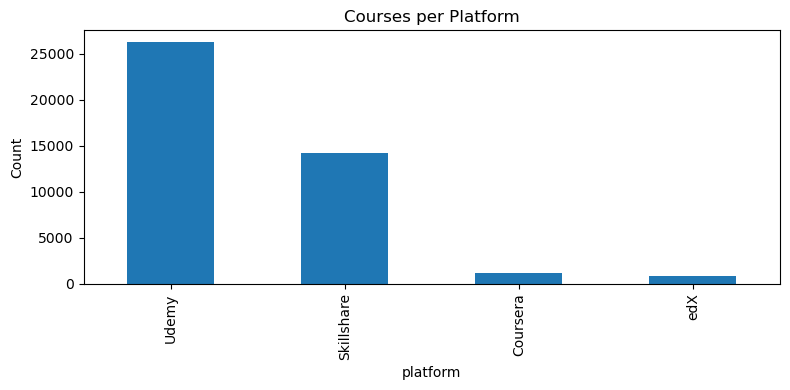

In [31]:
#EDA / VISUALIZATIONS
# -----------------------------
# Platform counts (safe plotting)
plt.figure(figsize=(8,4))
pc = df_clean['platform'].value_counts()
if pc.empty:
    print("No platform counts to plot.")
else:
    pc.plot(kind='bar')
    plt.title("Courses per Platform")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

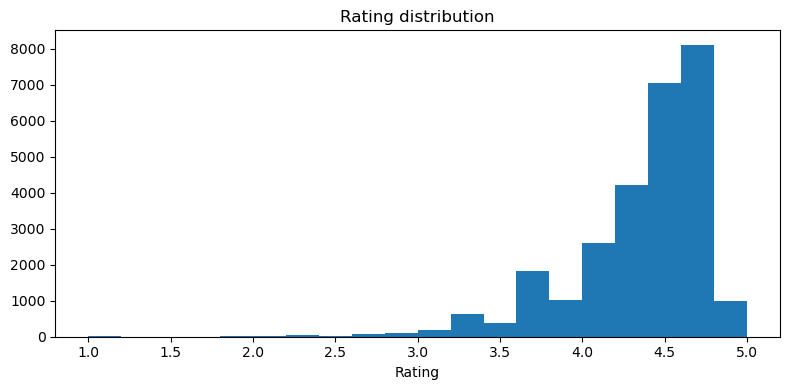

In [32]:

# Rating distribution
plt.figure(figsize=(8,4))
r = df_clean['rating'].dropna()
if len(r) > 0:
    plt.hist(r, bins=20)
    plt.title("Rating distribution")
    plt.xlabel("Rating")
    plt.tight_layout()
    plt.show()
else:
    print("No rating data to plot.")

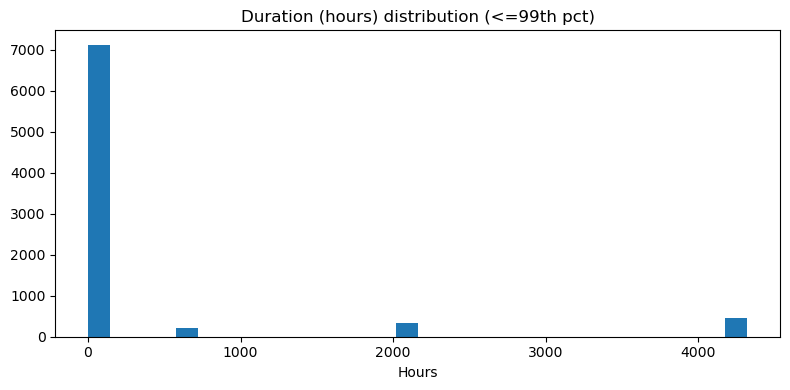

In [33]:

# Duration distribution (truncate at 99th percentile)
plt.figure(figsize=(8,4))
d = df_clean['duration_hours'].dropna()
if len(d) > 0:
    p99 = np.nanpercentile(d, 99)
    plt.hist(d[d<=p99], bins=30)
    plt.title("Duration (hours) distribution (<=99th pct)")
    plt.xlabel("Hours")
    plt.tight_layout()
    plt.show()
else:
    print("No duration data to plot.")

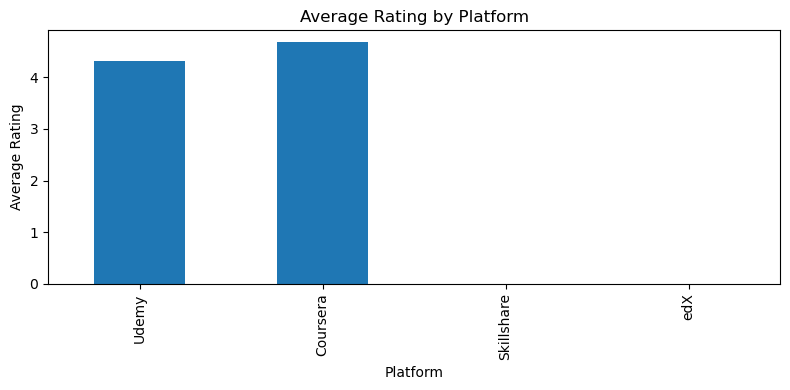

In [40]:
plt.figure(figsize=(8,4))
rating_platform = df_clean.groupby("platform")["rating"].mean().sort_values()
rating_platform.plot(kind="bar")
plt.title("Average Rating by Platform")
plt.xlabel("Platform")
plt.ylabel("Average Rating")
plt.tight_layout()
plt.show()


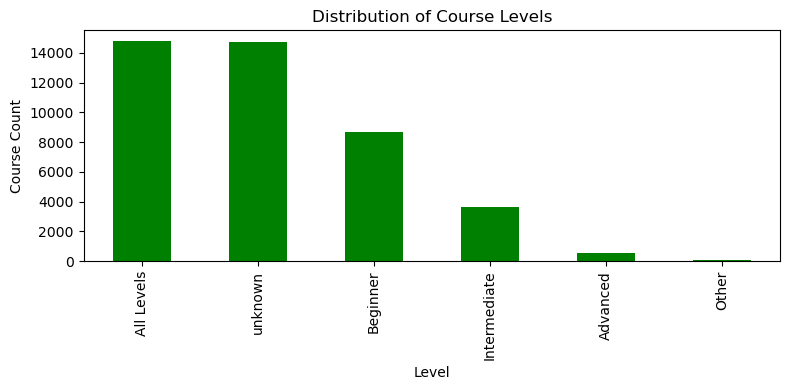

In [42]:
plt.figure(figsize=(8,4))
df_clean["level"].value_counts().plot(kind="bar", color="green")
plt.title("Distribution of Course Levels")
plt.xlabel("Level")
plt.ylabel("Course Count")
plt.tight_layout()
plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_2108\1850524376.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=df_clean['platform'].unique())


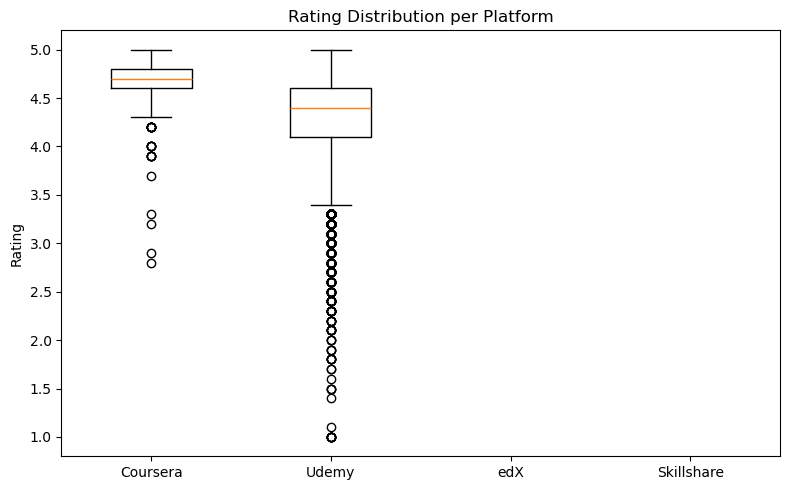

In [43]:
plt.figure(figsize=(8,5))
data = [df_clean[df_clean['platform']==p]['rating'].dropna() 
        for p in df_clean['platform'].unique()]

plt.boxplot(data, labels=df_clean['platform'].unique())
plt.title("Rating Distribution per Platform")
plt.ylabel("Rating")
plt.tight_layout()
plt.show()


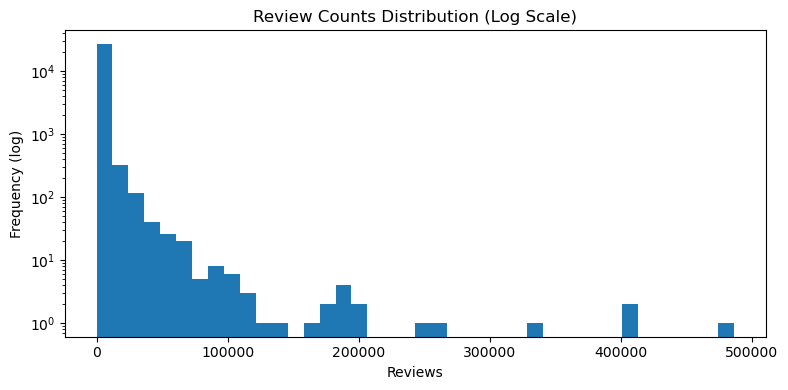

In [44]:
plt.figure(figsize=(8,4))
reviews = df_clean["reviews"].dropna()
plt.hist(reviews, bins=40)
plt.yscale("log")
plt.title("Review Counts Distribution (Log Scale)")
plt.xlabel("Reviews")
plt.ylabel("Frequency (log)")
plt.tight_layout()
plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_2108\887540363.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(dur_data, labels=df_clean["platform"].unique())


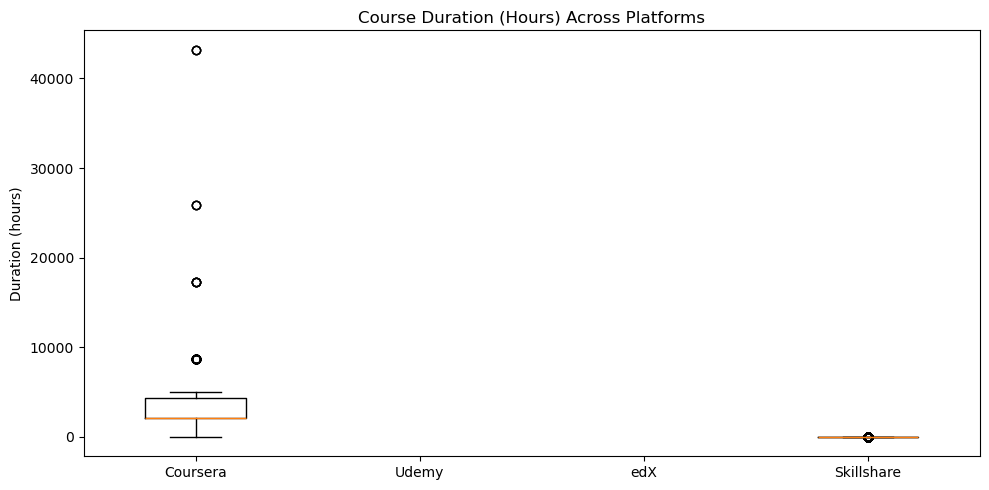

In [45]:
plt.figure(figsize=(10,5))
dur_data = [df_clean[df_clean["platform"]==plat]["duration_hours"].dropna()
           for plat in df_clean["platform"].unique()]

plt.boxplot(dur_data, labels=df_clean["platform"].unique())
plt.title("Course Duration (Hours) Across Platforms")
plt.ylabel("Duration (hours)")
plt.tight_layout()
plt.show()


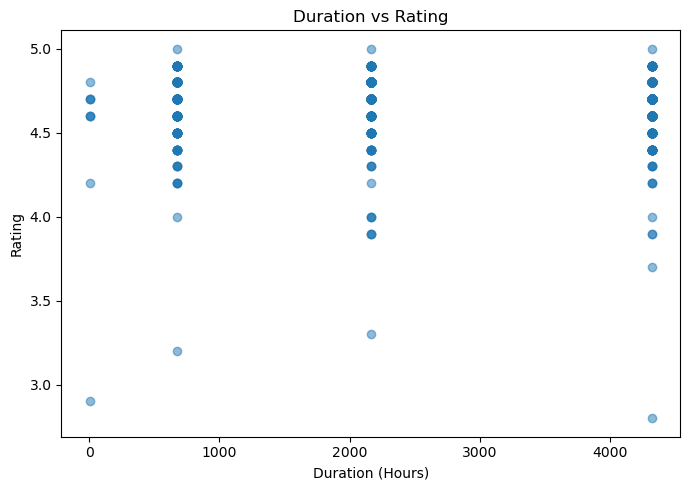

In [46]:
plt.figure(figsize=(7,5))
mask = df_clean["duration_hours"].notna() & df_clean["rating"].notna()
plt.scatter(df_clean.loc[mask,"duration_hours"], 
            df_clean.loc[mask,"rating"], alpha=0.5)
plt.xlabel("Duration (Hours)")
plt.ylabel("Rating")
plt.title("Duration vs Rating")
plt.tight_layout()
plt.show()


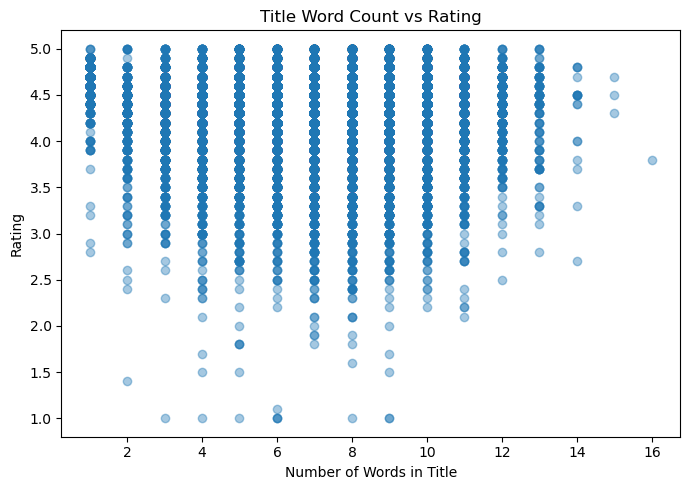

In [47]:
plt.figure(figsize=(7,5))
plt.scatter(df_clean["title_word_count"], df_clean["rating"], alpha=0.4)
plt.title("Title Word Count vs Rating")
plt.xlabel("Number of Words in Title")
plt.ylabel("Rating")
plt.tight_layout()
plt.show()


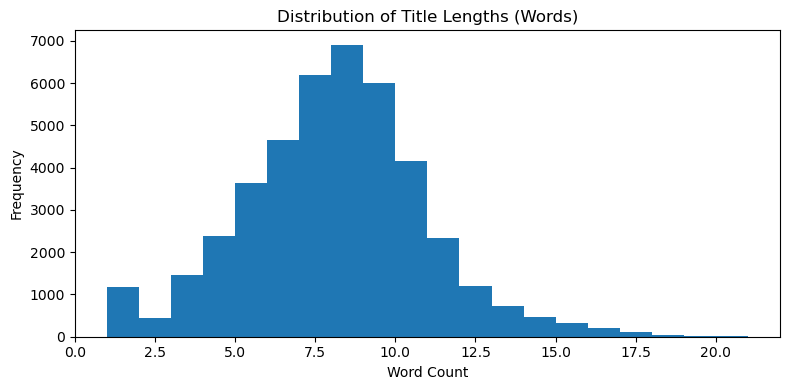

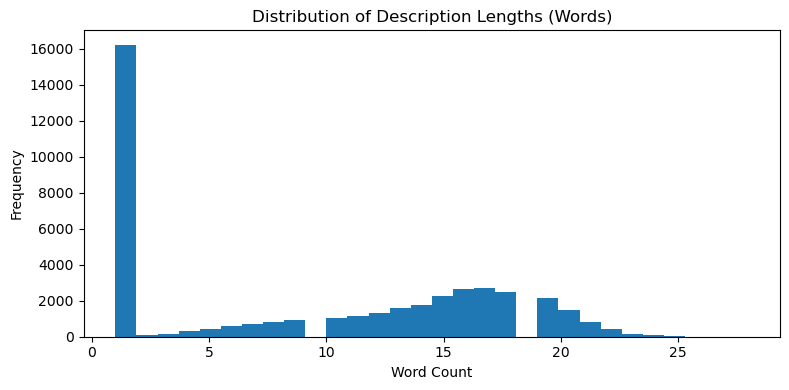

In [50]:
plt.figure(figsize=(8,4))
plt.hist(df_clean["title_word_count"], bins=20)
plt.title("Distribution of Title Lengths (Words)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.hist(df_clean["description_word_count"], bins=30)
plt.title("Distribution of Description Lengths (Words)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()



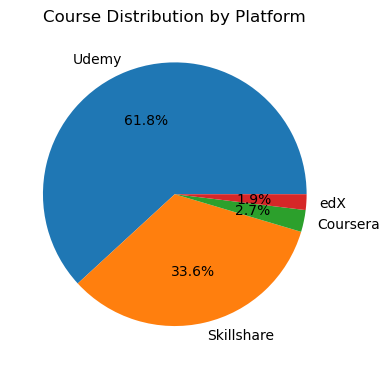

In [52]:
plt.figure(figsize=(4,4))
df_clean["platform"].value_counts().plot(kind="pie", autopct="%1.1f%%")
plt.title("Course Distribution by Platform")
plt.ylabel("")
plt.tight_layout()
plt.show()


In [35]:
from collections import Counter

# Top words in titles (simple)
all_titles = " ".join(df_clean['title'].fillna('').astype(str).tolist()).lower()
tokens = re.findall(r'\b[a-z]{2,}\b', all_titles)
stopwords = set(['and','for','with','the','in','of','to','a','an','learn','course','introduction','using','on','by'])
tokens = [t for t in tokens if t not in stopwords]
top20 = Counter(tokens).most_common(20)
print("\nTop 20 title words:")
for w,c in top20:
    print(f"{w}: {c}")


Top 20 title words:
your: 3406
how: 3145
beginners: 2993
complete: 2799
guide: 2094
design: 2021
from: 1903
create: 1651
python: 1623
watercolor: 1510
beginner: 1489
data: 1351
business: 1275
trading: 1255
build: 1235
master: 1215
masterclass: 1177
nan: 1171
advanced: 1169
management: 1160


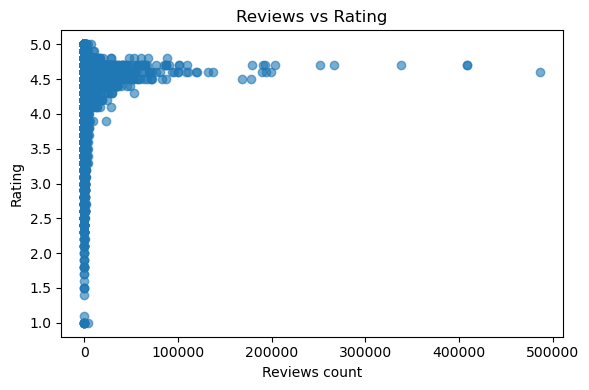

In [36]:

# Reviews vs Rating scatter (if enough data)
mask = df_clean['rating'].notna() & df_clean['reviews'].notna()
if mask.sum() > 10:
    plt.figure(figsize=(6,4))
    plt.scatter(df_clean.loc[mask,'reviews'], df_clean.loc[mask,'rating'], alpha=0.6)
    plt.xlabel("Reviews count")
    plt.ylabel("Rating")
    plt.title("Reviews vs Rating")
    plt.tight_layout()
    plt.show()
else:
    print("\nNot enough paired reviews & rating to scatter.")

In [37]:
# 8) SIMPLE MODEL: Predict rating from numeric features
# -----------------------------
# Prepare model DataFrame
model_df = df_clean[['rating','reviews','duration_hours','title_word_count','description_word_count']].copy()
# drop rows without target
model_df = model_df.dropna(subset=['rating']).reset_index(drop=True)


In [38]:
# If predictor columns have NaNs fill with median
for col in ['reviews','duration_hours','title_word_count','description_word_count']:
    if col in model_df.columns:
        if model_df[col].isna().all():
            model_df[col] = model_df[col].fillna(0)
        else:
            model_df[col] = model_df[col].fillna(model_df[col].median())

print("\nRows available for modeling:", len(model_df))


Rows available for modeling: 27249


In [39]:
if len(model_df) >= 50:
    X = model_df[['reviews','duration_hours','title_word_count','description_word_count']].values
    y = model_df['rating'].values
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"\nRandomForest results: MAE={mae:.4f}, R2={r2:.4f}, test_samples={len(y_test)}")
    fi = pd.DataFrame({
        'feature': ['reviews','duration_hours','title_word_count','description_word_count'],
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    print("\nFeature importances:\n", fi.to_string(index=False))
else:
    print("Not enough data to build the model (need >=50 rows with rating).")



RandomForest results: MAE=0.3152, R2=-0.0993, test_samples=5450

Feature importances:
                feature  importance
               reviews    0.516971
description_word_count    0.249531
      title_word_count    0.232769
        duration_hours    0.000728
